# Used car price prediction with ML algorithms

The following project aims to analyze a dataset containing data about audi cars to extract useful insights and to eventually develop a ML algorithm to predict the price of a used audi car given some fesatures.<br>
The best ML algorithm for regression was Xgboost optimized by Hyperopt baesian optimization with a R2 score=0.95 and RMSE=2448$ 

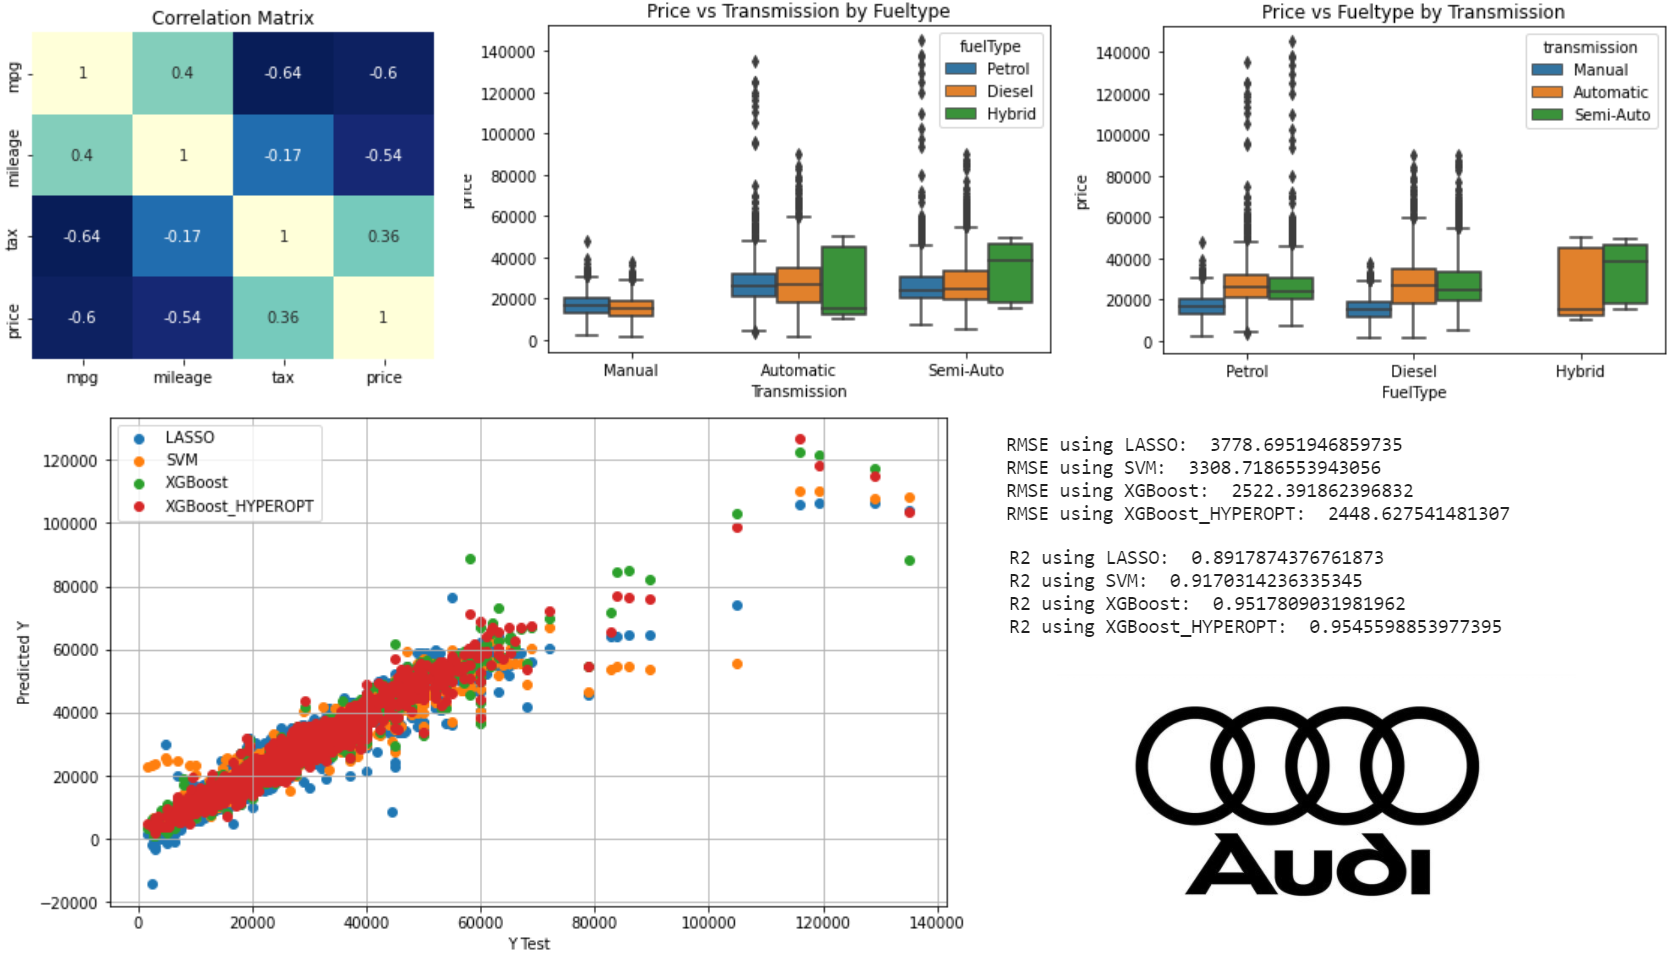
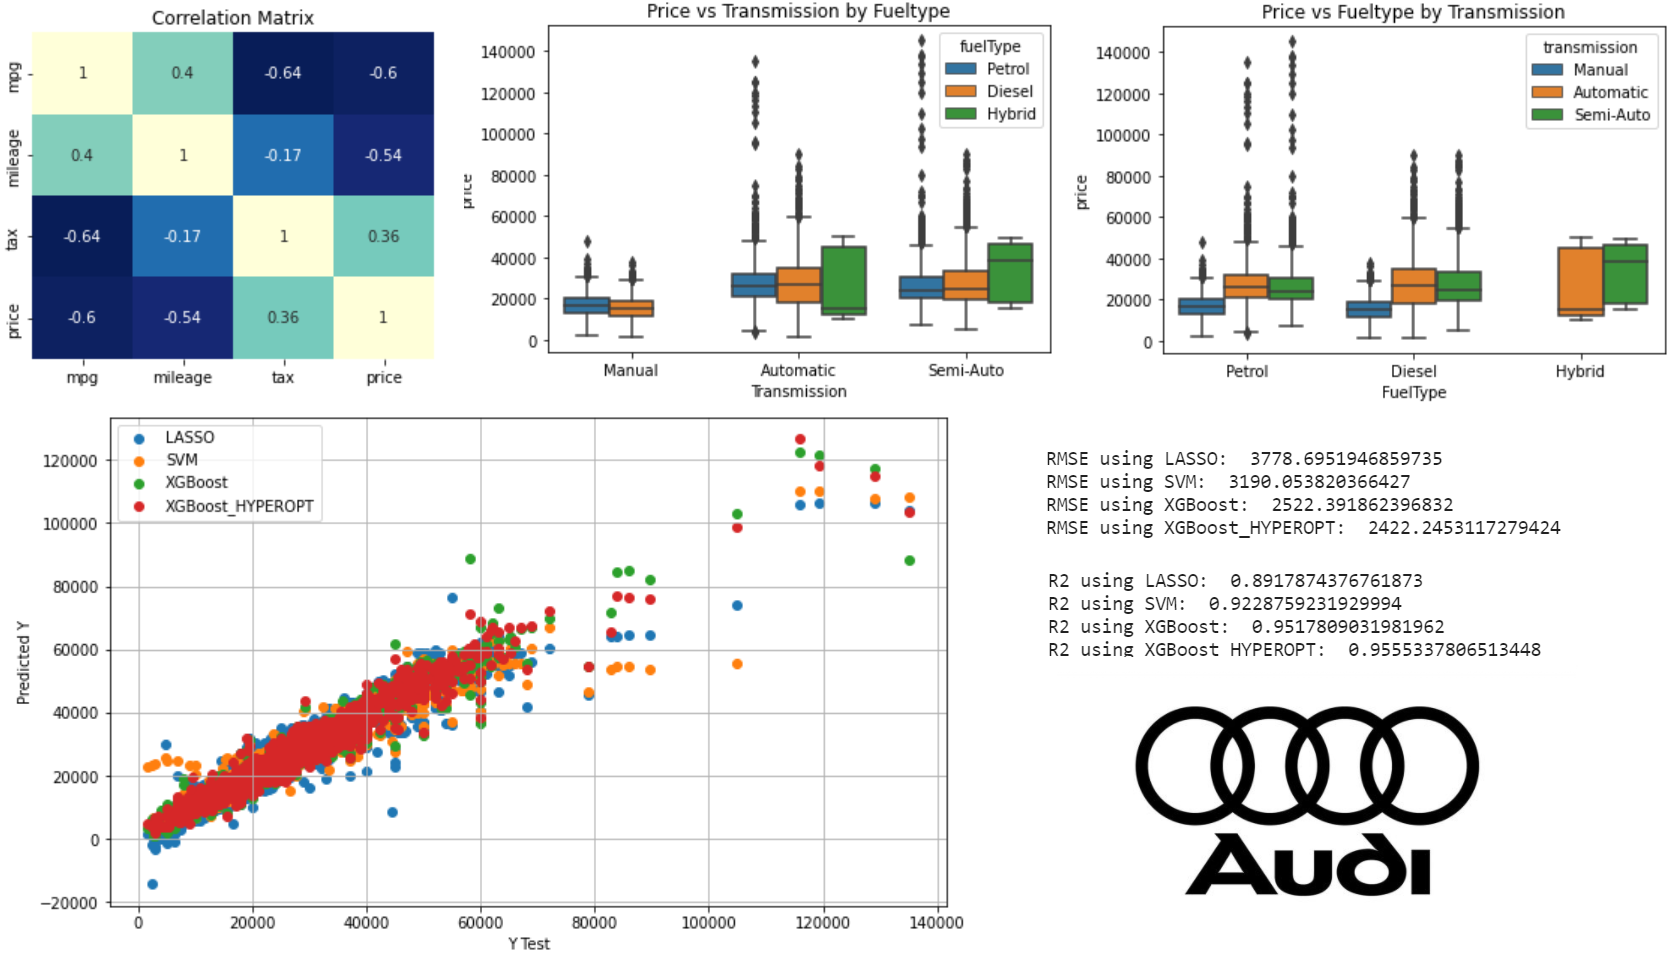

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [86]:
df=pd.read_csv('audi.csv',skipinitialspace=True)

During the model deployment, I noticed that the values in the model columns had a blank space in front. For this reason, I decided to add "skipinitialspace=True" during the creation of the dataframe.

In [87]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


I will reorder the columns to group the categorical variables first and then the numerical ones

In [88]:
df=df[['model','year','transmission','fuelType','mileage','tax','mpg','engineSize','price']]

In [89]:
df.head(10)

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
0,A1,2017,Manual,Petrol,15735,150,55.4,1.4,12500
1,A6,2016,Automatic,Diesel,36203,20,64.2,2.0,16500
2,A1,2016,Manual,Petrol,29946,30,55.4,1.4,11000
3,A4,2017,Automatic,Diesel,25952,145,67.3,2.0,16800
4,A3,2019,Manual,Petrol,1998,145,49.6,1.0,17300
5,A1,2016,Automatic,Petrol,32260,30,58.9,1.4,13900
6,A6,2016,Automatic,Diesel,76788,30,61.4,2.0,13250
7,A4,2016,Manual,Diesel,75185,20,70.6,2.0,11750
8,A3,2015,Manual,Petrol,46112,20,60.1,1.4,10200
9,A1,2016,Manual,Petrol,22451,30,55.4,1.4,12000


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10668 non-null  object 
 1   year          10668 non-null  int64  
 2   transmission  10668 non-null  object 
 3   fuelType      10668 non-null  object 
 4   mileage       10668 non-null  int64  
 5   tax           10668 non-null  int64  
 6   mpg           10668 non-null  float64
 7   engineSize    10668 non-null  float64
 8   price         10668 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 750.2+ KB


We can see that there are no missing values.

# Exploratory Data Analysis

## Analysis of engine size and mpg for each car model

First, we need to understand if excluding the mileage, which heavily depends on the owner of the car, the other features uniquely identify a car or not.

In [91]:
df_models=df.drop(['price','mileage','tax'], axis=1).drop_duplicates().sort_values(by=['model','year','fuelType'])
df_models.head()

,model,year,transmission,fuelType,mpg,engineSize
10632,A1,2010,Automatic,Petrol,53.3,1.4
9625,A1,2011,Manual,Diesel,70.6,1.6
9791,A1,2011,Manual,Petrol,53.3,1.4
7950,A1,2012,Manual,Diesel,74.3,1.6
8101,A1,2012,Manual,Diesel,68.9,2.0


Apparently the mpg and engineSize are not uniquely identified by the car model, year, transmission and fuelType.

Let's consider a possible query from a customer:

In [92]:
# Example of possible query from the user:
feat=['A1','2017','Manual','Petrol','15735','150']

In [93]:
df_models.loc[(df['model']==feat[0]) & (df_models['year']==int(feat[1])) & (df_models['transmission']==feat[2]) & (df_models['fuelType']==feat[3])]

,model,year,transmission,fuelType,mpg,engineSize
0,A1,2017,Manual,Petrol,55.4,1.4
36,A1,2017,Manual,Petrol,67.3,1.0
94,A1,2017,Manual,Petrol,58.9,1.4
334,A1,2017,Manual,Petrol,57.6,1.4
548,A1,2017,Manual,Petrol,56.5,1.4
1376,A1,2017,Manual,Petrol,39.8,2.0
3228,A1,2017,Manual,Petrol,70.6,1.4
5675,A1,2017,Manual,Petrol,39.2,2.0
7782,A1,2017,Manual,Petrol,40.4,2.0


We can clearly see the mpg and enginesize can vary for the same car model of the same year.<br>
This means that the car owner should manually input the values when the model will be deployed.

## Categorical features Analysis

In the following, categorical features will be analyzed

In [94]:
#Convert year column to object so we can include it in the categorical mask
df['year']=df['year'].astype(object)

In [95]:
# Create a boolean mask for categorical columns
categorical_mask = (df.dtypes == object)

In [96]:
categorical_columns = df.columns[categorical_mask].tolist()

In [97]:
print(df[categorical_columns].head())

  model  year transmission fuelType
0    A1  2017       Manual   Petrol
1    A6  2016    Automatic   Diesel
2    A1  2016       Manual   Petrol
3    A4  2017    Automatic   Diesel
4    A3  2019       Manual   Petrol


In [98]:
df_cat=df[categorical_columns]

In [99]:
df_cat['price']=df['price'];

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [100]:
df_cat.head()

,model,year,transmission,fuelType,price
0,A1,2017,Manual,Petrol,12500
1,A6,2016,Automatic,Diesel,16500
2,A1,2016,Manual,Petrol,11000
3,A4,2017,Automatic,Diesel,16800
4,A3,2019,Manual,Petrol,17300


### How is the fueltype related to the price?

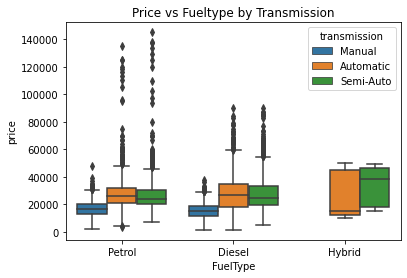

In [101]:
sns.boxplot(x='fuelType', y='price', data=df_cat, hue='transmission');
plt.xlabel('FuelType');
plt.title('Price vs Fueltype by Transmission');

We can see that Petrol cars are more expensive and present lots of outliers values. In particular, among the Petrol cars, those with Automatic and Semi-Auto transmission appears to be the most expensive, while the cars with a manual transimission are cheaper.<br>
Hybrid cars looks like to have no outliers.

### How is the Transmission related to the price?

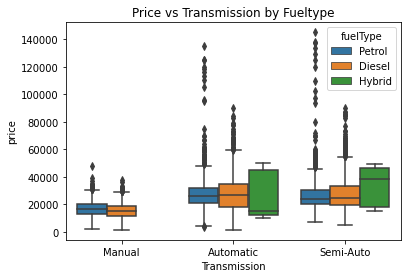

In [102]:
sns.boxplot(x='transmission', y='price', data=df_cat, hue='fuelType');
plt.xlabel('Transmission');
plt.title('Price vs Transmission by Fueltype');

From this plot it is possible to assert that cars with an Automatic or Semi-Automatic transmission are on average more expensive than cars with manual transmission. In particular, it is possible to say that while cars with manual transmission have a more similar price, cars with automatic or semi-auto transmission have a wider range of prices. Finally, Hybrid cars looks to have a more similar price with no outliers.

## Numerical featurs analysis

In [103]:
#create a dataframe with only the numerical features
df_num=df[['mpg','mileage','tax', 'price']]
df_num.head()

,mpg,mileage,tax,price
0,55.4,15735,150,12500
1,64.2,36203,20,16500
2,55.4,29946,30,11000
3,67.3,25952,145,16800
4,49.6,1998,145,17300


### How are tax and mpg related to the price?

In [104]:
corr=df_num.corr()

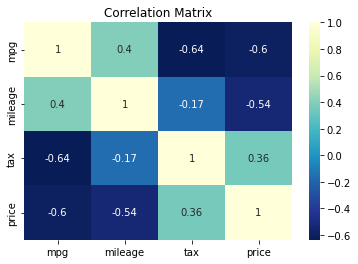

In [105]:
sns.heatmap(corr,annot=True, cmap='YlGnBu_r')
plt.title('Correlation Matrix');

From the heatmap, we can say the following about the price:<br>
There is a quite moderate negative correlation (-0.6) between the mpg and the price. This means that cars with high mpg tends to be cheaper.<br>
There is a quite moderate negatvie correlation (-0.54) between the mileage and the price. This means that cars with a higher mileage then to be cheaper.<br>
There is a small positive correlation also between the tax and the price. Cars with higher tax tends to cost more.

Other interesting information not related to the price are:<br>
There is a moderate positive correlation (0.4) between the mpg and mileage: cars with high mpg tends to have a higher mileage<br>
There is a quite moderate negative correaltion (-0.6) between tax and mpg. Cars with high mpg tends to have low tax.





# Data Preparation for modeling

The categorical features will be encoded by one hot encoding (OHE). This method is preferred compared to the pandas function 'get_dummies' since for model deployment we must to be able to export the encoding model for reproducibility.

## One Hot encoding

In [106]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(df[categorical_columns])

OneHotEncoder()

In [107]:
df[categorical_columns].head()

,model,year,transmission,fuelType
0,A1,2017,Manual,Petrol
1,A6,2016,Automatic,Diesel
2,A1,2016,Manual,Petrol
3,A4,2017,Automatic,Diesel
4,A3,2019,Manual,Petrol


In [108]:
import pickle
import joblib
#the encoder can be exported via joblib or pickle
pickle.dump(enc, open('encoder.pkl','wb'))
joblib.dump(enc, 'encoder.joblib')
# both joblib and pickle works the same in this case

['encoder.joblib']

In [109]:
df_encode = df[categorical_columns]
df_encode = pd.DataFrame(data=enc.transform(df_encode).toarray(),columns=enc.get_feature_names(categorical_columns), dtype=bool)
# trasfer true and false to 1 and 0
df_encode = df_encode * 1

# concatenate data
df_OHE = pd.concat((df.drop(categorical_columns, axis=1), df_encode), axis=1)
df_OHE.head()

,mileage,tax,mpg,engineSize,price,model_A1,model_A2,model_A3,model_A4,model_A5,...,year_2017,year_2018,year_2019,year_2020,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol
0,15735,150,55.4,1.4,12500,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
1,36203,20,64.2,2.0,16500,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,29946,30,55.4,1.4,11000,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,25952,145,67.3,2.0,16800,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
4,1998,145,49.6,1.0,17300,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1


In [110]:
encoded_df=df_OHE
encoded_df.head()

,mileage,tax,mpg,engineSize,price,model_A1,model_A2,model_A3,model_A4,model_A5,...,year_2017,year_2018,year_2019,year_2020,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol
0,15735,150,55.4,1.4,12500,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
1,36203,20,64.2,2.0,16500,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,29946,30,55.4,1.4,11000,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,25952,145,67.3,2.0,16800,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
4,1998,145,49.6,1.0,17300,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1


I have 58 columns: 5 (numeric_cols) + 53 (unique cateogric_cols) = 58

Now the data is ready for the learning

## Prepare the data for learning

In [111]:
X=encoded_df.drop('price', axis = 1).values

In [112]:
y=encoded_df['price'].values

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 69)

In [114]:
scaler = StandardScaler()

In [115]:
scaler.fit(X_train)

StandardScaler()

In [116]:
X_train = scaler.transform(X_train)          # Apply Standardization on X_train
X_test = scaler.transform(X_test)            # Apply Standardization on X_test

In [117]:
import pickle

In [118]:
#For model deployment, we need to pickle the scaler to scale the new input data from the user
pickle.dump(scaler, open('scaler.pkl','wb'))

## Linear Regression

In [119]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso

In [120]:
lm = LinearRegression()

In [121]:
lm.fit(X_train,y_train)

LinearRegression()

In [122]:
y_pred_lm = lm.predict(X_test)

In [123]:
mse_lm = mean_squared_error(y_test, y_pred_lm)
print("RMSE using LM: ", np.sqrt(mse_lm))

RMSE using LM:  7631080148332.435


In [124]:
lm_lasso=Lasso(alpha = 2, max_iter = 10000, tol = 1e-5)
lm_lasso.fit(X_train,y_train)
y_pred_lm_lasso = lm_lasso.predict(X_test)
mse_lm_lasso = mean_squared_error(y_test, y_pred_lm_lasso)
print("RMSE using LASSO: ", np.sqrt(mse_lm_lasso))

RMSE using LASSO:  3778.6951946859735


In [125]:
from sklearn.svm import SVR

In [126]:
param_SVM = {'C':[1000,2000,3000,5000,6000,7000,8000],
            'gamma':[0.0001,0.001,0.03,0.05,0.1,0.2,0.5]}

In [127]:
svr_model=SVR()

In [128]:
cv_SVM = RandomizedSearchCV(estimator=svr_model, param_distributions = param_SVM, n_iter=10, cv = 3)

In [129]:
cv_SVM.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=SVR(),
                   param_distributions={'C': [1000, 2000, 3000, 5000, 6000,
                                              7000, 8000],
                                        'gamma': [0.0001, 0.001, 0.03, 0.05,
                                                  0.1, 0.2, 0.5]})

In [130]:
y_pred_SVM = cv_SVM.predict(X_test)

In [131]:
# Compute and print the metrics
print("Tuned SVM parameters: {}".format(cv_SVM.best_params_))

Tuned SVM parameters: {'gamma': 0.03, 'C': 7000}


In [132]:
mse_SVM = mean_squared_error(y_test, y_pred_SVM)
print("RMSE using SVM: ", np.sqrt(mse_SVM))

RMSE using SVM:  3308.7186553943056


## XGBoost

In [133]:
import xgboost as xgb

In [134]:
# Create the parameter grid
param_grid = {
    'learning_rate': np.arange(0.01, 0.5, 0.01),
    'max_depth': np.arange(3, 30, 2),
    'n_estimators': np.arange(50, 200, 15)
}

In [135]:
xgb_model=xgb.XGBRegressor()

In [136]:
rand_neg_mse = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=10, scoring='neg_mean_squared_error', cv=3)

In [137]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [138]:
y_pred_xgb = xgb_model.predict(X_test)

In [139]:
from sklearn.metrics import mean_squared_error as MSE

In [140]:
print("Best rmse:", np.sqrt(MSE(y_pred_xgb,y_test)))

Best rmse: 2522.391862396832


## XGBoost with HYPEROPT Baesian optimization

In [152]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [153]:
space={'n_estimators':hp.choice('n_estimators', np.arange(2,30,1)),
       'max_depth': hp.choice("max_depth", np.arange(2, 20, 1)),
       'eta': hp.quniform('eta', 0.001, 0.8, 0.001),
        'gamma': hp.quniform('gamma', 0, 10, 0.1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
       'subsample' : hp.quniform('subsample', 0.01, 1, 0.01),
       'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)
      }

In [154]:
def hyperparameter_tuning(space):
    print(space)
    model = xgb.XGBRegressor(n_estimators=space['n_estimators'],
                             max_depth =space['max_depth'],
                             eta=space['eta'],
                             gamma=space['gamma'],
                           min_child_weight=space['min_child_weight'],
                            colsample_bytree=space['colsample_bytree'],
                            subsample=space['subsample'])

    eval_set  = [( X_train, y_train), ( X_test, y_test)]

    model.fit(X_train, y_train,
            eval_set=eval_set, eval_metric="rmse",
            early_stopping_rounds=15,verbose=False)

    pred = model.predict(X_test)
    mse_scr = mean_squared_error(y_test, pred)
    print("SCORE:", np.sqrt(mse_scr))
    #change the metric if you like
    return {'loss':mse_scr, 'status': STATUS_OK }

In [155]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print (best)

{'colsample_bytree': 0.55, 'eta': 0.181, 'gamma': 5.0, 'max_depth': 14, 'min_child_weight': 8.0, 'n_estimators': 21, 'subsample': 0.52}
SCORE:                                                 
2757.671693728051                                      
{'colsample_bytree': 0.38, 'eta': 0.513, 'gamma': 7.9, 'max_depth': 11, 'min_child_weight': 2.0, 'n_estimators': 17, 'subsample': 0.87}
SCORE:                                                                         
2784.1920308398235                                                             
{'colsample_bytree': 0.8200000000000001, 'eta': 0.79, 'gamma': 9.600000000000001, 'max_depth': 7, 'min_child_weight': 3.0, 'n_estimators': 24, 'subsample': 0.9}
SCORE:                                                                         
2762.9503235981438                                                             
{'colsample_bytree': 0.97, 'eta': 0.156, 'gamma': 9.9, 'max_depth': 15, 'min_child_weight': 1.0, 'n_estimators': 24, 'subsample': 0.1}


In [156]:
print("The best hyperparameters are : ","\n")
print(best)

The best hyperparameters are :  

{'colsample_bytree': 0.76, 'eta': 0.319, 'gamma': 1.6, 'max_depth': 16, 'min_child_weight': 3.0, 'n_estimators': 26, 'subsample': 0.76}


In [157]:
xgb_opt = xgb.XGBRegressor(n_estimators=best['n_estimators'],
                             max_depth =best['max_depth'],
                           min_child_weight=best['min_child_weight'],
                           gamma = best['gamma'],
                            colsample_bytree=best['colsample_bytree'],
                            subsample=best['subsample'])

In [158]:
xgb_opt.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.76, gamma=1.6, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=16,
             min_child_weight=3.0, missing=nan, monotone_constraints='()',
             n_estimators=26, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.76,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [159]:
# Predicting the Test set results
y_pred_XGB_OPT = xgb_opt.predict(X_test)

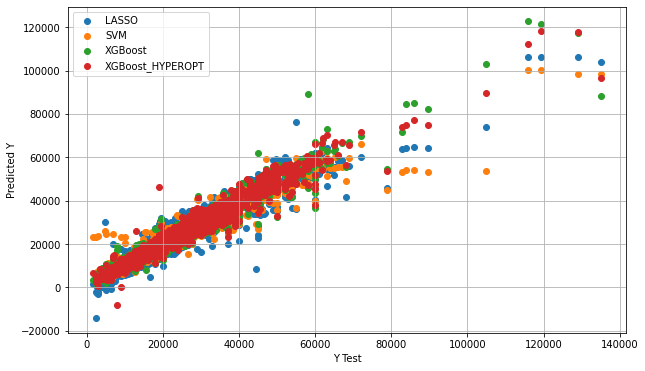

In [160]:
plt.figure(figsize = (10,6))
plt.scatter(y_test, y_pred_lm_lasso, label='LASSO')
plt.scatter(y_test, y_pred_SVM, label='SVM')
plt.scatter(y_test, y_pred_xgb, label='XGBoost')
plt.scatter(y_test, y_pred_XGB_OPT, label='XGBoost_HYPEROPT')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.legend(loc='upper left');
plt.grid()

In [161]:
mse_XGB_OPT = mean_squared_error(y_test, y_pred_XGB_OPT)
print("RMSE using LASSO: ", np.sqrt(mse_lm_lasso))
print("RMSE using SVM: ", np.sqrt(mse_SVM))
print("RMSE using XGBoost: ", np.sqrt(MSE(y_pred_xgb,y_test)))
print("RMSE using XGBoost_HYPEROPT: ", np.sqrt(mse_XGB_OPT))

RMSE using LASSO:  3778.6951946859735
RMSE using SVM:  3308.7186553943056
RMSE using XGBoost:  2522.391862396832
RMSE using XGBoost_HYPEROPT:  2448.627541481307


In [162]:
from sklearn.metrics import r2_score
print("R2 using LASSO: ", r2_score(y_test, y_pred_lm_lasso))
print("R2 using SVM: ",  r2_score(y_test, y_pred_SVM))
print("R2 using XGBoost: ", r2_score(y_test, y_pred_xgb))
print("R2 using XGBoost_HYPEROPT: ", r2_score(y_test, y_pred_XGB_OPT))

R2 using LASSO:  0.8917874376761873
R2 using SVM:  0.9170314236335345
R2 using XGBoost:  0.9517809031981962
R2 using XGBoost_HYPEROPT:  0.9545598853977395


By looking at the RMSE and R2 scores, we can conclude that the best performing algorithm is Xgboost.